In [1]:
import warnings
warnings.filterwarnings('ignore')
from fastai.core import *
from fastai.torch_core import *
from fastai.imports.torch import *
from fastai.tabular.data import *
from fastai.tabular.transform import *
from fastai.data import *
from fastai.tabular.models import *
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
import seaborn as sns

%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 0

Autosave disabled


## Generate data
#### Create input features - x1, x2, and x3 - and their effect on the reponse variable through the scale object. We'll later pass scale to numpy's `random.gamma()` method to generate a gamma-distributed response variable.

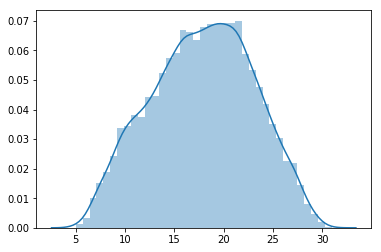

In [2]:
n = 10000
np.random.seed(90210)
x1 = np.random.uniform(0, 5, n)
x2 = np.random.normal(100, 20, n)
x3 = np.random.choice((1,2,3,4,5), n, p = (0.35, 0.2, 0.05, 0.25, 0.15))
scale = np.clip(3.2 * x1 + 0.05 * x2 + 2.15 * x3 - 0.12*x1*x3, a_min = 5, a_max = 1e15)
sns.distplot(scale)

#### Observation weights, `w`, will also be randomly generated. Each record in the dataset will be observed between 0.5 and 1.5 time units. This type of data often appears in modeling problems where observation periods vary between records in the dataset or when new records are created when something about the observational unit changes throughout the observation period. It is very common in insurance modeling, for instance.

In [3]:
w = np.random.uniform(0.5, 1.5, n)

#### Bundle the input features into both a numpy array and then a pandas dataframe.

In [4]:
x = np.stack((x1, x2, x3), axis = 1)
df = pd.DataFrame(x, columns = ['x1', 'x2', 'x3'])

#### Finally, create a gamma-distributed response variable, `y`, which is assumed to have a scale parameter defined by the linear combination of the input features encoded into scale with a constant shape parameter of 1.2.

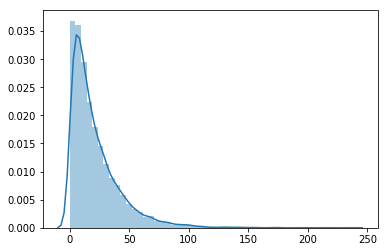

In [5]:
y = np.random.gamma(shape = 1.2, scale = scale, size = n)
y_range = [0., y.max()]
sns.distplot(y)

#### Insert the observations weights, `w`, and response, `y`,  into the dataframe

In [6]:
df['w'] = w
df['y'] = y

#### Split data into training and validation and specify categorical for continuous variables

In [7]:
val_idxs = np.random.permutation(len(y))[:3000]
train_df = df[~df.index.isin(val_idxs)]
valid_df = df[ df.index.isin(val_idxs)]

cats = ['x3']
conts = ['x1', 'x2']

## Customize fastai
#### Create a subclass from `TabularDataset` called `TabularDataset_ow` that accepts observation weights. The `_ow` stands for **o**bservation  __w__eights

In [8]:
OptTabTfms = Optional[Collection[TabularTransform]]
class TabularDataset_ow(TabularDataset):
    "Class for tabular data."
    def __init__(self, wgt_var:str, df:DataFrame, *args, **kwargs):
        super().__init__(df, *args, **kwargs)
        if not is_numeric_dtype(df[wgt_var]): df[wgt_var] = df[wgt_var].cat.astype(np.int64)
        self.w = np2model_tensor(df[wgt_var].values)
        
    def __getitem__(self, idx)->Tuple[Tuple[LongTensor,FloatTensor,FloatTensor], Tensor]:
        return ((self.cats[idx], self.conts[idx]), [self.y[idx], self.w[idx]])
    
    @classmethod
    def from_dataframe(cls, df:DataFrame, dep_var:str, wgt_var:str, tfms:OptTabTfms=None, cat_names:OptStrList=None,
                       cont_names:OptStrList=None, stats:OptStats=None, log_output:bool=False)->'TabularDataset':
        "Create a tabular dataframe from df after applying optional transforms."
        if cat_names is None: cat_names = [n for n in df.columns if is_categorical_dtype(df[n])]
        if cont_names is None: cont_names = [n for n in df.columns if is_numeric_dtype(df[n]) and not n==dep_var]
        if tfms is None: tfms = []
        for i,tfm in enumerate(tfms):
            if isinstance(tfm, TabularTransform): tfm(df, test=True)
            else:
                tfm = tfm(cat_names, cont_names)
                tfm(df)
                tfms[i] = tfm
                cat_names, cont_names = tfm.cat_names, tfm.cont_names
        ds = cls(wgt_var, df, dep_var, cat_names, cont_names, stats, log_output)
        ds.tfms,ds.cat_names,ds.cont_names = tfms,cat_names,cont_names
        return ds

#### Customize the code to create DataLoaders. Again, we add an `_ow` suffix

In [9]:
def tabular_data_from_df_ow(path, train_df:DataFrame, valid_df:DataFrame, dep_var:str, wgt_var:str, test_df:OptDataFrame=None,
                            tfms:OptTabTfms=None, cat_names:OptStrList=None, cont_names:OptStrList=None,
                            stats:OptStats=None, log_output:bool=False, **kwargs)->DataBunch:
    "Create a `DataBunch` from train/valid/test dataframes."
    cont_names = ifnone(cont_names, list(set(train_df)-set(cat_names)-{dep_var}))
    train_ds = TabularDataset_ow.from_dataframe(train_df, dep_var, wgt_var, tfms, cat_names, cont_names, stats, log_output)
    valid_ds = TabularDataset_ow.from_dataframe(valid_df, dep_var, wgt_var, train_ds.tfms, train_ds.cat_names,
                                             train_ds.cont_names, train_ds.stats, log_output)
    datasets = [train_ds, valid_ds]
    if test_df is not None:
        datasets.append(TabularDataset_ow.from_dataframe(test_df, dep_var, wgt_var, train_ds.tfms, train_ds.cat_names,
                                                      train_ds.cont_names, train_ds.stats, log_output))
    return DataBunch.create(*datasets, path=path, **kwargs)

## Specify the model

In [10]:
dep_var = 'y'
wgt_var = 'w'
tfms = [Categorify]
db = tabular_data_from_df_ow('.', train_df, valid_df, dep_var, wgt_var, tfms = tfms,
                             cat_names = cats, cont_names = conts, bs = 128)

In [11]:
cat_szs = [len(train_df[n].cat.categories)+1 for n in cats]
emb_szs = [(c, min(10, (c+1)//2)) for c in cat_szs]

In [12]:
model = TabularModel(emb_szs = emb_szs, n_cont = len(conts), out_sz = 1, layers = [5],
                     ps = [0.], emb_drop = 0.02, y_range = y_range, use_bn = True)
opt = optim.SGD(model.parameters(), lr = 1e-4)

#### Now that we have observation weights in our datasets and data loaders, we need to make sure our model's loss function and our evaluation metric that we'll be using to monitor learning can accept observational weights. Not doing so will cause an error. PyTorch doesn't supply weighted loss functions, so we'll need to create our own. Deviance, which is a general distance measure between prediction and response that accounts for non-nomal response distributions, is a good choice for our loss function. It is proportional to negative loglikelihood. See https://en.wikipedia.org/wiki/Deviance_(statistics). To monitor training we'll use weighted Mean Absolute Error.

In [13]:
def wgtd_dev(prds, resp, wgts = None):
    if wgts is None: wgts = torch.tensor(1.0).repeat(resp.shape)
    prds.data.clamp_(min = 1e-5) # predictions must be positive
    dev = -2.0 * wgts * (torch.log(resp/prds) - (resp - prds) / prds)
    return dev.sum() / wgts.sum()

def wgtd_mae(prds, resp, wgts = None):
    if wgts is None: wgts = torch.tensor(1.0).repeat(resp.shape)
    ae = torch.abs(prds - resp)
    return ae.sum() / wgts.sum()

## Fit the model
#### Write a custom `fit()` function just to show how the validation loss would need to be updated. The only thing that would need to change is how the `nums` are appended

In [16]:
epochs = 5

In [17]:
def fit():
    for epoch in range(epochs):
        model.train()
        for xb,yb in db.train_dl:
            pred = model(*xb)
            if not is_listy(yb): yb = [yb]
            loss = wgtd_dev(pred, *yb)
    
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        losses,metrics,nums = [],[],[]
        with torch.no_grad():
            for xb,yb in db.valid_dl:
                pred = model(*xb)
                if not is_listy(yb): yb = [yb]
                losses.append(wgtd_dev(pred, *yb))
                metrics.append(wgtd_mae(pred, *yb))
                # next line represents changes to get weighted average over
                # each batch
                nums.append(yb[-1].sum() if len(yb) > 1 else yb[0].shape[0])
            nums = np.array(nums, dtype=np.float32)
            loss = (to_np(torch.stack(losses)) * nums).sum() / nums.sum()
            metric = (to_np(torch.stack(metrics)) * nums).sum() / nums.sum()
        print(epoch, loss, metric)

In [18]:
fit()

0 2.8090737 95.27724
1 2.8068244 95.182434
2 2.7998152 94.76205
3 2.7951686 94.419235
4 2.7912931 94.13127


## Make sure everything works without observation weights
#### Recreate databunch object using fastai defaults

In [20]:
db = tabular_data_from_df('.', train_df, valid_df, dep_var, tfms = tfms,
                         cat_names = cats, cont_names = conts, bs = 128)

In [21]:
fit()

0 2.7745118 93.70315
1 2.7714806 93.489
2 2.770622 93.44292
3 2.7638133 92.973915
4 2.7633183 92.95105
